In [582]:
import pandas as pd
import numpy as np
import requests
import bs4
from bs4 import BeautifulSoup
from tflearn.data_utils import to_categorical
from collections import Counter, defaultdict
from sklearn.feature_extraction import stop_words

In [583]:
results = pd.read_csv('indeed-results.csv')
results.head()

,location,title,company,salary,summary
0,"New York, NY 10261 (Murray Hill area)",Data Scientist,MassMutual Financial Group,NaN,MassMutual’s Advanced Analytics group is seeki...
1,"New York, NY",Data Scientist,HarperCollins Publishers Inc.,NaN,"Uses mid to large-scale machine learning, data..."
2,"New York, NY 10016 (Gramercy area)",Data Scientist,Simulmedia,NaN,You will find yourself working with other data...
3,"New York, NY",Data Science Analyst,AIG,NaN,§ Stay current on the latest machine learning ...
4,"New York, NY",Data Scientist,PulsePoint,NaN,"MS/PhD in Astronomy, Physics, Applied Mathemat..."


In [584]:
results.shape

(12745, 5)

In [585]:
# count = salaries['summary'].str.split().str.len()
# count.index = count.index.astype(str) + ' words:'
# count.sort_index(inplace=True)
#count

## Data Wrangling & Preprocessing


In [586]:
salaries_sal = results[results.salary.notnull()]
salaries_summ = salaries_sal[salaries_sal.summary.notnull()]
salaries = salaries_summ[salaries_summ.company.notnull()]

In [587]:
salaries.dtypes

location    object
title       object
company     object
salary      object
summary     object
dtype: object

In [588]:
salaries.head()

,location,title,company,salary,summary
24,"New York, NY",Data Scientist,indify,"$90,000 - $170,000 a year",Indify data scientists contribute to all aspec...
50,"New York, NY 10031 (Hamilton Heights area)",Computer Science (Data Analysis) Instructor,"Urban Scholars Program, City College of Ne...",$40 an hour,"Data, data filtering, basic spreadsheet operat..."
63,"New York, NY",Data Scientist,WorldCover,"$70,000 - $110,000 a year",Your primary focus will be in applying data mi...
79,"New York, NY",Data Scientist,Scienaptic Systems Inc,"$100,000 a year","As our representative in front of client, you ..."
98,"New York, NY 10038 (Financial District area)",Data Scientist,Enterprise Select,"$130,000 a year",Deep knowledge of applied statistics and machi...


In [589]:
#salaries.title.value_counts().index

In [590]:
salaries.shape

(686, 5)

In [591]:
salaries = salaries[(~salaries.salary.str.contains('an hour')) & (~salaries.salary.str.contains('a month'))
                   & (~salaries.salary.str.contains('a week')) & (~salaries.salary.str.contains('a day'))]

In [592]:
salaries.salary = salaries.salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')

In [593]:
salaries.shape

(494, 5)

In [594]:
for i in salaries.salary:
    if len(i.split('-')) != 1 and len(i.split('-')) != 2:
        print(i)

In [595]:
new_salaries = []
for i in salaries.salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))

In [596]:
new_salaries[0:5]

[130000.0, 90000.0, 100000.0, 130000.0, 75000.0]

In [597]:
salaries.salary = new_salaries

In [598]:
salaries.head()

,location,title,company,salary,summary
24,"New York, NY",Data Scientist,indify,130000.0,Indify data scientists contribute to all aspec...
63,"New York, NY",Data Scientist,WorldCover,90000.0,Your primary focus will be in applying data mi...
79,"New York, NY",Data Scientist,Scienaptic Systems Inc,100000.0,"As our representative in front of client, you ..."
98,"New York, NY 10038 (Financial District area)",Data Scientist,Enterprise Select,130000.0,Deep knowledge of applied statistics and machi...
105,"New York, NY",Senior Research Analyst,Research Foundation of The City Univer...,75000.0,Overseeing all project activities related to d...


In [599]:
salaries.shape

(494, 5)

In [600]:
salaries.duplicated().sum()

0

In [601]:
salaries.isnull().sum()

location    0
title       0
company     0
salary      0
summary     0
dtype: int64

In [602]:
#display null columns

null_columns=salaries.columns[salaries.isnull().any()]
print(salaries[salaries.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


In [603]:
salaries.head()

,location,title,company,salary,summary
24,"New York, NY",Data Scientist,indify,130000.0,Indify data scientists contribute to all aspec...
63,"New York, NY",Data Scientist,WorldCover,90000.0,Your primary focus will be in applying data mi...
79,"New York, NY",Data Scientist,Scienaptic Systems Inc,100000.0,"As our representative in front of client, you ..."
98,"New York, NY 10038 (Financial District area)",Data Scientist,Enterprise Select,130000.0,Deep knowledge of applied statistics and machi...
105,"New York, NY",Senior Research Analyst,Research Foundation of The City Univer...,75000.0,Overseeing all project activities related to d...


In [604]:
##### dist plotting

In [605]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


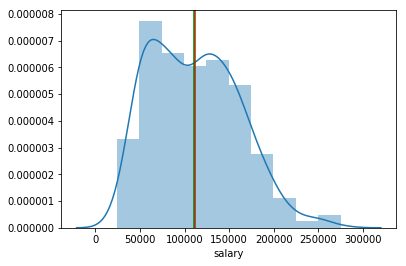

In [606]:
ax = sns.distplot(salaries['salary'], bins=10)
ax.axvline(salaries['salary'].mean(), c='r')
ax.axvline(salaries['salary'].median(), c='g')

In [607]:
twentieth = salaries['salary'].quantile(0.20)
eightieth = salaries['salary'].quantile(0.80)

In [608]:
median_salary = np.median(salaries.salary)
median_salary

110000.0

In [609]:
salaries['high_salary'] = [1 if i > median_salary else 0 for i in salaries.salary]

## Pre processing for vectorization

In [610]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split

In [611]:
## Count Number of words in each summary of job

salaries['word_count'] = salaries['summary'].apply(lambda x: len(str(x).split(" ")))
salaries[['summary','word_count']].head()

,summary,word_count
24,Indify data scientists contribute to all aspec...,24
63,Your primary focus will be in applying data mi...,22
79,"As our representative in front of client, you ...",26
98,Deep knowledge of applied statistics and machi...,21
105,Overseeing all project activities related to d...,20


In [612]:
## Count Number of characters in each summary of job

salaries['char_count'] = salaries['summary'].str.len() ## this also includes spaces
salaries[['summary','char_count']].head()

,summary,char_count
24,Indify data scientists contribute to all aspec...,143
63,Your primary focus will be in applying data mi...,158
79,"As our representative in front of client, you ...",162
98,Deep knowledge of applied statistics and machi...,161
105,Overseeing all project activities related to d...,153


In [613]:
#check for stop words

import nltk
#nltk.download()
from nltk.corpus import stopwords
stop = stopwords.words('english')

salaries['stopwords'] = salaries['summary'].apply(lambda x: len([x for x in x.split() if x in stop]))
salaries[['summary','stopwords']].head()

,summary,stopwords
24,Indify data scientists contribute to all aspec...,12
63,Your primary focus will be in applying data mi...,6
79,"As our representative in front of client, you ...",11
98,Deep knowledge of applied statistics and machi...,6
105,Overseeing all project activities related to d...,5


In [614]:
## make everything lowercase

salaries['summary'] = salaries['summary'].apply(lambda x: x.lower())
salaries['summary'].head()

24     indify data scientists contribute to all aspec...
63     your primary focus will be in applying data mi...
79     as our representative in front of client, you ...
98     deep knowledge of applied statistics and machi...
105    overseeing all project activities related to d...
Name: summary, dtype: object

In [615]:
# Remove punctuations

salaries['summary'] = salaries['summary'].str.replace('[^\w\s]','')
salaries['summary'].head()


24     indify data scientists contribute to all aspec...
63     your primary focus will be in applying data mi...
79     as our representative in front of client you w...
98     deep knowledge of applied statistics and machi...
105    overseeing all project activities related to d...
Name: summary, dtype: object

In [616]:
# Check for rare words

freq = pd.Series(' '.join(salaries['summary']).split()).value_counts()[-10:]
freq

server            1
wtchr             1
hypothesis        1
contractor        1
independently     1
darian            1
home              1
wishing           1
uncertain         1
statisticsmath    1
dtype: int64

In [617]:
# Correct Spellings

# import textblob
# from textblob import TextBlob
# salaries['summary'][:5].apply(lambda x: str(TextBlob(x).correct()))

In [618]:
#Remove Stop words

stop = stopwords.words('english')
salaries['summary']  = salaries['summary'] .apply(lambda x: " ".join(x for x in x.split() if x not in stop))
salaries['summary'].head()

24     indify data scientists contribute aspects plat...
63     primary focus applying data mining techniques ...
79     representative front client opportunity constr...
98     deep knowledge applied statistics machine lear...
105    overseeing project activities related data col...
Name: summary, dtype: object

In [619]:
## Stemming

from nltk.stem import PorterStemmer
st = PorterStemmer()
salaries['summary'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
salaries['summary'].head()

24     indify data scientists contribute aspects plat...
63     primary focus applying data mining techniques ...
79     representative front client opportunity constr...
98     deep knowledge applied statistics machine lear...
105    overseeing project activities related data col...
Name: summary, dtype: object

In [620]:
## Lemmatization

from textblob import Word
salaries['summary'] = salaries['summary'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
salaries['summary'].head()

24     indify data scientist contribute aspect platfo...
63     primary focus applying data mining technique s...
79     representative front client opportunity constr...
98     deep knowledge applied statistic machine learn...
105    overseeing project activity related data colle...
Name: summary, dtype: object

In [621]:
###replace everything except the letters and numbers in the spaces.


salaries['summary'] = salaries['summary'].replace('[^a-zA-Z0-9]', ' ', regex = True)
salaries['summary'].head(5)


24     indify data scientist contribute aspect platfo...
63     primary focus applying data mining technique s...
79     representative front client opportunity constr...
98     deep knowledge applied statistic machine learn...
105    overseeing project activity related data colle...
Name: summary, dtype: object

In [622]:
salaries.shape

(494, 9)

In [623]:
salaries.summary.count()

494

In [624]:
#reset Index

salaries.reset_index(drop= True, inplace=True)
salaries.head()


,location,title,company,salary,summary,high_salary,word_count,char_count,stopwords
0,"New York, NY",Data Scientist,indify,130000.0,indify data scientist contribute aspect platfo...,1,24,143,12
1,"New York, NY",Data Scientist,WorldCover,90000.0,primary focus applying data mining technique s...,0,22,158,6
2,"New York, NY",Data Scientist,Scienaptic Systems Inc,100000.0,representative front client opportunity constr...,0,26,162,11
3,"New York, NY 10038 (Financial District area)",Data Scientist,Enterprise Select,130000.0,deep knowledge applied statistic machine learn...,1,21,161,6
4,"New York, NY",Senior Research Analyst,Research Foundation of The City Univer...,75000.0,overseeing project activity related data colle...,0,20,153,5


## Split Train and Test Data

In [629]:
import sklearn.cross_validation
sklearn.model_selection.train_test_split
X = salaries['summary']
Y = salaries['salary']
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X, Y, test_size = 0.33, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
X_train.head()

(330,)
(164,)
(330,)
(164,)


410    responsibility include conducting environmenta...
152    talented group data scientist developer pm des...
79     director data science lead team experienced da...
76     statistical modeling machine learning experien...
333    data team consists three data analyst three da...
Name: summary, dtype: object

## Vectorize Summary column using Tfidf Vectorizer 

In [658]:
# from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# vectorizer = TfidfVectorizer()
# X_tfidf = vectorizer.fit_transform(X_train) 
# print(X_tfidf)
# vect = CountVectorizer().fit(X_train)
# vect

In [659]:

# used words (axis in our multi-dimensional space)
# vectorizer.get_feature_names()[::2]


In [661]:
# from sklearn.decomposition import PCA
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.pipeline import Pipeline
# pipeline = Pipeline([
#     ('vect', CountVectorizer()),
#     ('tfidf', TfidfTransformer()),
# ])        
# Xtrain = pipeline.fit_transform(X_train).todense()
# Xtest = pipeline.fit_transform(X_test).todense()

# pca_xtrain = PCA(n_components=1).fit(Xtrain)
# pca_xtest = PCA(n_components=1).fit(Xtest)

# X_train_data = pca_xtrain.transform(Xtrain)
# X_test_data = pca_xtest.transform(Xtest)

# X_train_data
#plt.scatter(data2D[:,0], data2D[:,1], c='r')
#plt.show() 

## Plotting the graph of Linear Regression

In [645]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(salaries['summary'], salaries['salary'], random_state = 0)

In [646]:
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 indify data scientist contribute aspect platform vital part envisioning creating future product


X_train shape:  (370,)


In [578]:
dataframe.head()

,summary,salary
24,indify data scientist contribute aspect platfo...,130000.0
63,primary focus applying data mining technique s...,90000.0
79,representative front client opportunity constr...,100000.0
98,deep knowledge applied statistic machine learn...,130000.0
105,overseeing project activity related data colle...,75000.0


In [647]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(X_train)

In [649]:
vect.get_feature_names()[::300]

['02', 'commoner', 'functional', 'motivation', 'sale']

In [650]:
len(vect.get_feature_names())

1487

In [651]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<370x1487 sparse matrix of type '<class 'numpy.int64'>'
	with 5021 stored elements in Compressed Sparse Row format>

In [652]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_vectorized, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [654]:
from sklearn.metrics import r2_score
predictions = model.predict(vect.transform(X_test))
print("R^2 score for Linear Regression: ",model.score(vect.transform(X_test), y_test))

R^2 score for Linear Regression:  0.08389688129844075


In [664]:
#Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer(min_df = 5).fit(X_train)
len(vect.get_feature_names())

229

In [665]:
X_train_vectorized = vect.transform(X_train)

model = LinearRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
print("R^2 score for Linear Regression: ",model.score(vect.transform(X_test), y_test))

R^2 score for Linear Regression:  -1.4947459796970417


In [669]:
sorted_coef_index = model.coef_[0].argsort()
print(sorted_coef_index);
print('Smallest coef: \n{}\n'.format(feature_names[sorted_coef_index[:1]]))
print('Largest coef: \n{}\n'.format(feature_names[sorted_coef_index[:-11:-1]]))

[0]
Smallest coef: 
['02']

Largest coef: 
['02']



ValueError: x and y must be the same size

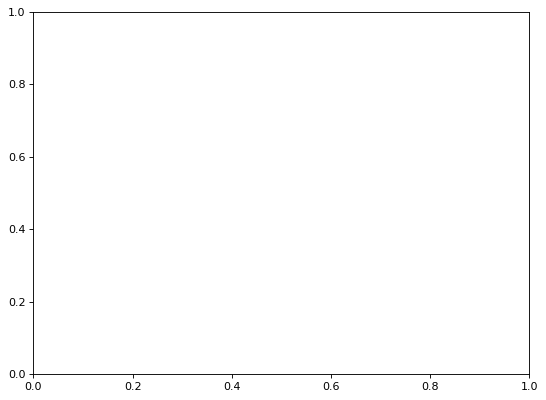

In [662]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(vect.transform(X_test), y_test, c='g')
#plt.scatter(X_train, y_train)
plt.plot(vect.transform(X_test), predictions, c='r')
plt.title("Linear Regression - Regressor")
plt.xlabel("Summary")
plt.ylabel("Salary  in $")
plt.show()